In [2]:
# ggplot
import matplotlib.pyplot as plt
from plotnine import *

# pandas
import numpy as np
import pandas as pd

# scipy
from scipy import stats
from sklearn import linear_model, metrics, preprocessing, model_selection
from sklearn.svm import SVR
# os, sys
import os
import sys

In [3]:
# !!! WARNING !!!
# THIS FILE RUNS IN /src/pyfiles/ DIRECTORY
# !!! WARNING !!!
if os.getcwd().split('/')[-1] == 'pyfiles':
    os.chdir('../..')
print("Current working directory is: ", os.getcwd())

Current working directory is:  /Volumes/cs-projects/sosc-demographics-ii


In [7]:
## Load a dataset
from io import StringIO

metadata = dict()
alcohol_consumption = None
with open(os.path.join('src', 'common', 'who-fha-db-pure_alcohol_consumption_1960_2015.csv'), 'r') as f:
    ## Seek the end of the header
    reader = f.readlines()
    rest = None
    for line in reader:
        if line.startswith('"COUNTRY"'):
            rest = reader[reader.index(line):]
            break
        elif len(line) < 2:
            continue
        else:
            key, value = [line.split(',')[0], "".join(line.split(',')[1:])]
            # remove quotes
            value = value.replace('"', '')
            # remove new line
            value = value.replace('\n', '')
            # remove trailing spaces
            value = value.strip()
            # remove unicoode special characters
            value = value.replace('\xa0', '')
            value = value.replace('\ufeff', '')
            metadata.update({
                key: value
            })
    ## Read the data
    alcohol_consumption = pd.read_csv(StringIO("".join(rest)), sep=",")
    alcohol_consumption = alcohol_consumption[alcohol_consumption["YEAR"] > 1989]
    alcohol_consumption = alcohol_consumption[alcohol_consumption["YEAR"] < 2000]
    alcohol_consumption = alcohol_consumption[alcohol_consumption["COUNTRY"].isin(['KAZ', "LTV", "LTU", "RUS", "UKR", "EST", "BLR", "ARM", "ALB"])]
    alcohol_consumption = alcohol_consumption[alcohol_consumption["SEX"] == "ALL"]
    alcohol_consumption.drop(columns=["COUNTRY_GRP", "SEX"], axis=1, inplace=True)
    alcohol_consumption.reset_index(inplace=True, drop=True)
    alcohol_consumption['YEAR'].astype(int)
    alcohol_consumption.columns = ['country', 'year', 'value']
alcohol_consumption

,country,year,value
0,ALB,1990.0,2.03
1,ALB,1991.0,1.28
2,ALB,1992.0,1.35
3,ALB,1993.0,1.49
4,ALB,1994.0,2.77
...,...,...,...
75,UKR,1995.0,3.72
76,UKR,1996.0,3.26
77,UKR,1997.0,3.98
78,UKR,1998.0,3.74


In [8]:
## Load a dataset
from io import StringIO

metadata = dict()
mortality = None
with open(os.path.join('src', 'common', 'euro-mortality-db-mortality_1968-2018.csv'), 'r') as f:
    ## Seek the end of the header
    reader = f.readlines()
    rest = None
    for line in reader:
        if line.startswith('"COUNTRY"'):
            rest = reader[reader.index(line):]
            break
        elif len(line) < 2:
            continue
        else:
            key, value = [line.split(',')[0], "".join(line.split(',')[1:])]
            # remove quotes
            value = value.replace('"', '')
            # remove new line
            value = value.replace('\n', '')
            # remove trailing spaces
            value = value.strip()
            # remove unicoode special characters
            value = value.replace('\xa0', '')
            value = value.replace('\ufeff', '')
            metadata.update({
                key: value
            })
    ## Read the data
    mortality = pd.read_csv(StringIO("".join(rest)), sep=",")
    mortality = mortality[mortality["YEAR"] > 1989]
    mortality = mortality[mortality["YEAR"] < 2000]
    mortality = mortality[mortality["COUNTRY"].isin(['KAZ', "LTV", "LTU", "RUS", "UKR", "EST", "BLR", "ARM", "ALB"])]
    mortality = mortality[mortality["SEX"] == "ALL"]
    mortality = mortality[mortality["AGE_GRP_LIST"] == "TOTAL"]
    mortality.drop(columns=["COUNTRY_GRP", "SEX", "AGE_GRP_LIST"], axis=1, inplace=True)
    mortality.reset_index(inplace=True, drop=True)
    mortality['YEAR'].astype(int)
    mortality.columns = ['country', 'year', 'value']
    mortality["value"] = mortality["value"] 
mortality

,country,year,value
0,ALB,1992.0,17238.0
1,ALB,1993.0,16639.0
2,ALB,1994.0,14984.0
3,ALB,1995.0,16059.0
4,ALB,1996.0,16747.0
...,...,...,...
73,UKR,1995.0,792615.0
74,UKR,1996.0,776717.0
75,UKR,1997.0,754151.0
76,UKR,1998.0,719954.0


In [9]:
gdp = pd.read_csv(os.path.join('src', 'common', 'gdpexpanded.csv'))
# group by country
gdp = gdp.groupby(['Country or Area', 'Year']).mean().reset_index()
gdp = gdp[gdp['Year'] < 2000]
gdp = gdp[gdp['Year'] > 1989]
gdp.columns = ['country', 'year', 'value']
gdp["value"] = gdp["value"] 
gdp['country'] = gdp['country'].replace('Kazakhstan', 'KAZ')
gdp['country'] = gdp['country'].replace('Lithuania', 'LTU')
gdp['country'] = gdp['country'].replace('Latvia', 'LTV')
gdp['country'] = gdp['country'].replace('Estonia', 'EST')
gdp['country'] = gdp['country'].replace('Belarus', 'BLR')
gdp['country'] = gdp['country'].replace('Ukraine', 'UKR')
gdp['country'] = gdp['country'].replace('Armenia', 'ARM')
gdp['country'] = gdp['country'].replace('Albania', 'ALB')
gdp['country'] = gdp['country'].replace('Russian Federation', 'RUS')
# gdp = gdp[gdp["country"].isin(['KAZ', "LTV", "LTU"])]
gdp

/var/folders/zz/j6r_jn5d1n33632p2lfxbbgw0000gn/T/ipykernel_35107/1629375020.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,country,year,value
20,ALB,1990,651.201284
21,ALB,1991,483.676684
22,ALB,1992,458.914225
23,ALB,1993,515.173587
24,ALB,1994,571.023495
...,...,...,...
281,UKR,1995,986.577383
282,UKR,1996,911.687212
283,UKR,1997,1035.252563
284,UKR,1998,871.919769


In [10]:
sentiment = pd.read_csv(os.path.join('src', 'common', 'sentiment', 'parsed', 'sentiment.csv'))
sentiment.columns = ['null', 'sentiment', 'year', 'value']
sentiment.drop(columns=['null'], axis=1, inplace=True)
sentiment["value"] = sentiment["value"] * 1000
negative = sentiment[sentiment['sentiment'] == 'negative']
negative.drop(columns=['sentiment'], axis=1, inplace=True)
negative

/var/folders/zz/j6r_jn5d1n33632p2lfxbbgw0000gn/T/ipykernel_35107/2428123079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,year,value
0,1985,4.963165
1,1986,5.043631
2,1987,5.096436
3,1988,5.341873
4,1989,5.616179
5,1990,5.749890
6,1991,5.897967
7,1992,5.828993
8,1993,6.150658
9,1994,6.138634


In [108]:
data = None
data = pd.merge(alcohol_consumption, mortality, on=['country', 'year'])
data.columns = ['country', 'year', 'alcohol_consumption', 'mortality']
data = pd.merge(data, gdp, on=['country', 'year'])
data.columns = ['country', 'year', 'alcohol_consumption', 'mortality', 'gdp']
data = pd.merge(data, negative, on=['year'])
data.columns = ['country', 'year', 'alcohol_consumption', 'mortality', 'gdp', 'negative_sentiment']
data = data[data["year"] > 1994]
data = data[data["year"] < 2000]
# normalize for each country
for country in ['KAZ', "LTV", "LTU", "RUS", "UKR", "EST", "BLR", "ARM", "ALB"]:
    for feature in ['alcohol_consumption', 'mortality', 'gdp', 'negative_sentiment']:
        try:
            data.loc[data['country'] == country, feature] = preprocessing.scale(data.loc[data['country'] == country, feature])
        except:
            continue

data

,country,year,alcohol_consumption,mortality,gdp,negative_sentiment
24,ALB,1995.0,0.864394,-0.191913,-0.830506,1.622421
25,ARM,1995.0,0.948683,0.998737,-1.667141,1.622421
26,BLR,1995.0,-1.494054,-1.382641,-0.197124,1.622421
27,EST,1995.0,-0.031801,1.823937,-1.409963,1.622421
28,KAZ,1995.0,1.823331,1.186505,-0.409321,1.622421
29,LTU,1995.0,-1.377239,1.731455,-1.609577,1.622421
30,RUS,1995.0,1.469543,1.467766,0.779576,1.622421
31,UKR,1995.0,-0.023588,1.393487,0.722403,1.622421
32,ALB,1996.0,1.312731,1.215720,1.080345,0.450366
33,ARM,1996.0,0.813157,1.146123,-0.311487,0.450366


    correlation country             feature1             feature2
0      0.333696     KAZ            Mortality  Alcohol Consumption
1      0.332434     KAZ            Mortality                  GDP
2     -0.086184     KAZ  Alcohol Consumption                  GDP
3      1.000000     KAZ  Alcohol Consumption  Alcohol Consumption
4      1.000000     KAZ            Mortality            Mortality
..          ...     ...                  ...                  ...
91     0.331553     ALB   Negative Sentiment            Mortality
92     0.205192     ALB  Alcohol Consumption            Mortality
93     0.228269     ALB                  GDP  Alcohol Consumption
94     0.757258     ALB   Negative Sentiment  Alcohol Consumption
95    -0.402486     ALB   Negative Sentiment                  GDP

[96 rows x 4 columns]


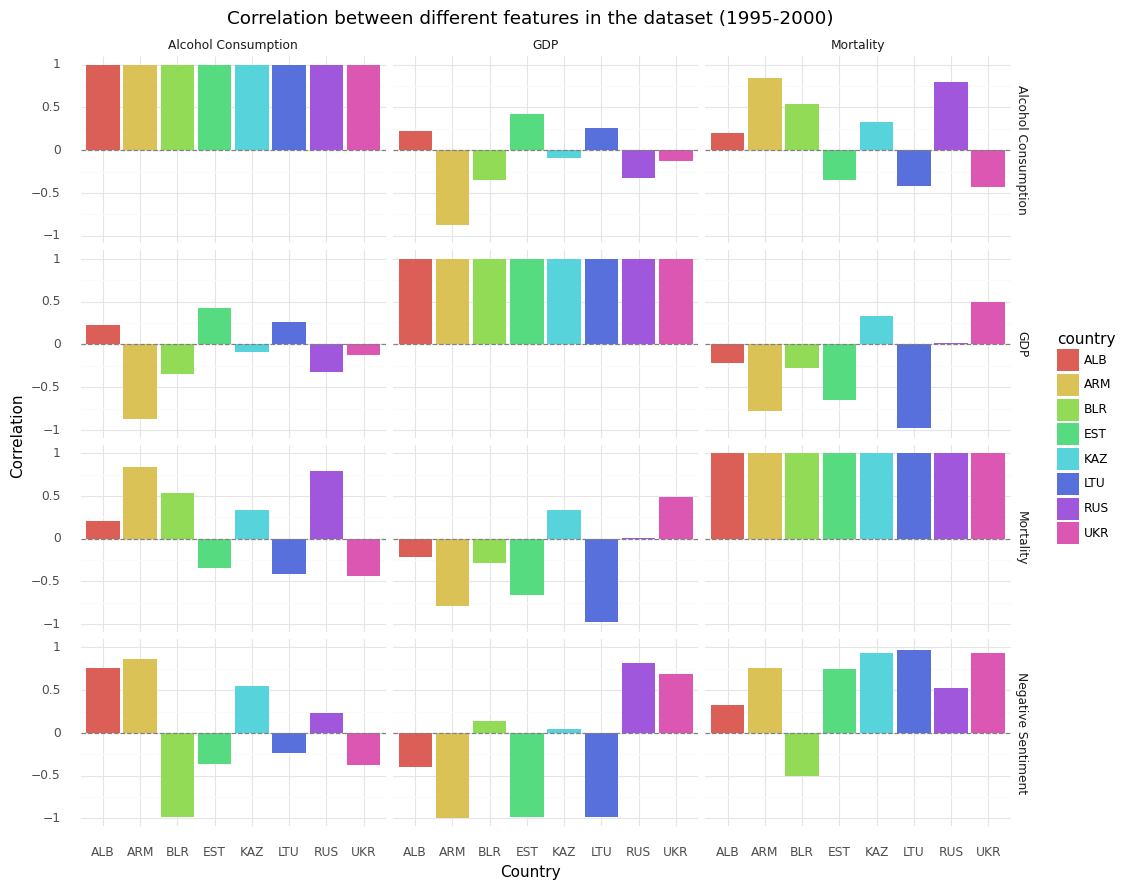

<ggplot: (369011129)>

In [110]:
correlations = {

}
# print correlations between features for each country
for country in ['KAZ', "LTU", "RUS", "UKR", "EST", "BLR", "ARM", "ALB"]:
    # mortality vs alcohol consumption
    correlations[(country, 'mortality', 'alcohol_consumption')] = data.loc[data['country'] == country, ['mortality', 'alcohol_consumption']].corr().iloc[0, 1]
    # mortality vs gdp
    correlations[(country, 'mortality', 'gdp')] = data.loc[data['country'] == country, ['mortality', 'gdp']].corr().iloc[0, 1]
    # alcohol consumption vs gdp
    correlations[(country, 'alcohol_consumption', 'gdp')] = data.loc[data['country'] == country, ['alcohol_consumption', 'gdp']].corr().iloc[0, 1]
    # alcohol consumption vs alcohol consumption
    correlations[(country, 'alcohol_consumption', 'alcohol_consumption')] = data.loc[data['country'] == country, ['alcohol_consumption', 'alcohol_consumption']].corr().iloc[0, 1]
    # mortality vs mortality
    correlations[(country, 'mortality', 'mortality')] = data.loc[data['country'] == country, ['mortality', 'mortality']].corr().iloc[0, 1]
    # gdp vs gdp
    correlations[(country, 'gdp', 'gdp')] = data.loc[data['country'] == country, ['gdp', 'gdp']].corr().iloc[0, 1]
    # gdp vs mortality
    correlations[(country, 'gdp', 'mortality')] = data.loc[data['country'] == country, ['gdp', 'mortality']].corr().iloc[0, 1]
    # negative sentiment vs mortality
    correlations[(country, 'negative_sentiment', 'mortality')] = data.loc[data['country'] == country, ['negative_sentiment', 'mortality']].corr().iloc[0, 1] 
    # alcohol consumption vs mortality
    correlations[(country, 'alcohol_consumption', 'mortality')] = data.loc[data['country'] == country, ['alcohol_consumption', 'mortality']].corr().iloc[0, 1]
    # alcohol consumption vs gdp
    correlations[(country, 'gdp','alcohol_consumption')] = data.loc[data['country'] == country, ['alcohol_consumption', 'gdp']].corr().iloc[0, 1]
    # # alcohol consumption vs negative sentiment
    correlations[(country , 'negative_sentiment','alcohol_consumption')] = data.loc[data['country'] == country, ['alcohol_consumption', 'negative_sentiment']].corr().iloc[0, 1] 
    # # negative sentiment vs gdp
    correlations[(country, 'negative_sentiment', 'gdp')] = data.loc[data['country'] == country, ['negative_sentiment', 'gdp']].corr().iloc[0, 1] 

correlations = pd.DataFrame.from_dict(correlations, orient='index')
correlations.columns = ['correlation']
correlations.reset_index(inplace=True)
correlations[['country', 'feature1', 'feature2']] = pd.DataFrame(correlations['index'].tolist(), index=correlations.index)
correlations['correlation'] = correlations['correlation']
for i in range(0,2):
    correlations[f"feature{i+1}"] = correlations[f"feature{i+1}"].replace('alcohol_consumption', 'Alcohol Consumption')
    correlations[f"feature{i+1}"] = correlations[f"feature{i+1}"].replace('mortality', 'Mortality')
    correlations[f"feature{i+1}"] = correlations[f"feature{i+1}"].replace('gdp', 'GDP')
    correlations[f"feature{i+1}"] = correlations[f"feature{i+1}"].replace('negative_sentiment', 'Negative Sentiment')
correlations.drop(columns=['index'], axis=1, inplace=True)
print(correlations)

# plot mortality vs alcohol consumption correlation for each country
plot = ggplot(correlations, aes(x='country', y='correlation', fill='country')) + \
    xlab('Country') + \
    ylab('Correlation') + \
    ggtitle('Correlation between different features in the dataset (1995-2000)') + \
    geom_bar(stat='identity') + \
    facet_grid('feature1 ~ feature2') + \
    theme(axis_text_x=element_text(rotation=90, hjust=1)) + \
    theme_minimal() + \
    theme(figure_size=(12, 10)) + \
    geom_hline(yintercept=0, linetype='dashed', color='gray') 
    
plot

Correlation between mortality and alcohol consumption for country KAZ: -0.6959578209980066
Correlation between mortality and gdp for country KAZ: -0.7020077206298293
Correlation between mortality and negative sentiment for country KAZ: 0.6984305699637113
Correlation between mortality and alcohol consumption for country LTV: nan
Correlation between mortality and gdp for country LTV: nan
Correlation between mortality and negative sentiment for country LTV: nan
Correlation between mortality and alcohol consumption for country LTU: -0.662315088751584
Correlation between mortality and gdp for country LTU: -0.9043904246738773
Correlation between mortality and negative sentiment for country LTU: 0.9650450751462538
Correlation between mortality and alcohol consumption for country RUS: 0.6589773112912214
Correlation between mortality and gdp for country RUS: -0.6364288481511398
Correlation between mortality and negative sentiment for country RUS: 0.7338452734303564
Correlation between mortality

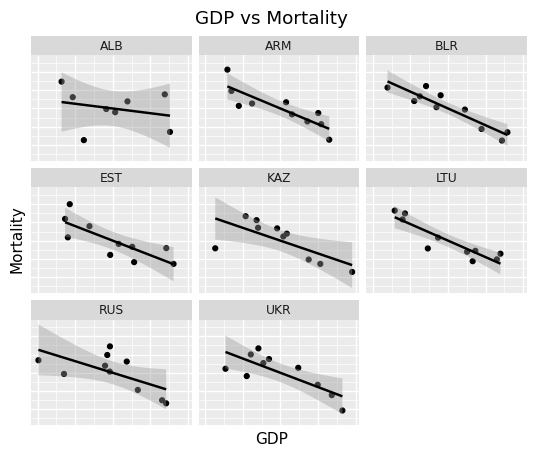

<ggplot: (367558493)>

In [29]:

# Plot some data
(
    ggplot(data, aes('gdp', y='mortality')) +
    facet_wrap('country') +
    geom_point() +
    geom_smooth(method='lm') +
    labs(title='GDP vs Mortality', x='GDP', y='Mortality') +
    theme(
        axis_text_x=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_y=element_blank(),
    )
)